## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem description

We will work with the __abalone__ dataset, where we wan to predict the number of rings in abalones, which should correspond to the age. 

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




#---------DATA------------
df = pd.read_csv("abalone.csv")
df = pd.get_dummies(df, drop_first=True)*1
#df = df.drop(["Sex"])
variable_names = list(df.loc[:,df.columns != "Rings"].columns)
X_original = df.loc[:,df.columns != "Rings"].values
y_original = df.loc[:,df.columns == "Rings"].values.T[0]
n, p = X_original.shape  # need this to get p 

print(n,p)

# Define BATCH sizes
BATCH_SIZE = int((n*0.8)/5)
TEST_BATCH_SIZE = int(n*0.10) 
VAL_BATCH_SIZE = int(n*0.10)

TRAIN_SIZE = int((n*0.80)/5)
TEST_SIZE = int(n*0.10)
VAL_SIZE = int(n*0.10)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

4177 9


# ReLU based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

In [4]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu_lime_shap", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

network 0
43809
0
loss 655968.875
nll 317.2153015136719
density 0.9993231015203315

val_loss: 897173.6875, val_nll: 241097.4375, val_ensemble: -56.5618, used_weights_median: 43809

1
loss 654850.0
nll 532.3838500976562
density 0.9993138125128413

val_loss: 850488.3750, val_nll: 195738.6094, val_ensemble: -45.7324, used_weights_median: 43809

2
loss 653124.3125
nll 140.90774536132812
density 0.9993040858726451

val_loss: 736051.8750, val_nll: 82628.6406, val_ensemble: -18.7275, used_weights_median: 43809

3
loss 651650.125
nll 1.362048864364624
density 0.9992939139493302

val_loss: 658307.2500, val_nll: 6210.4609, val_ensemble: -0.4827, used_weights_median: 43809

4
loss 650571.5
nll 257.8232421875
density 0.9992832618269206

val_loss: 666166.5000, val_nll: 15396.0508, val_ensemble: -2.6758, used_weights_median: 43809

5
loss 648988.3125
nll 10.028426170349121
density 0.9992720972615742

val_loss: 671832.7500, val_nll: 22388.6113, val_ensemble: -4.3453, used_weights_median: 43809

6
los

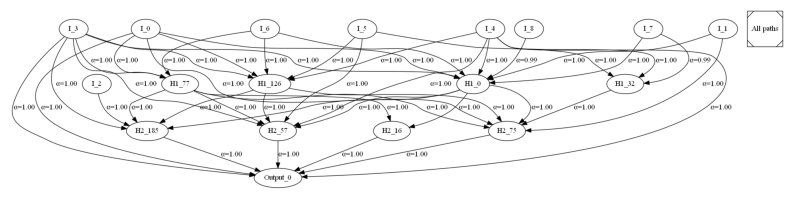

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 44 weights used in median model $\rightarrow$ density of 0.1\% compared to initialized model (43'809 weigths) 
* RMSE of 2.06 for median model
* RMSE of 13.94 for full model (did 1000 epochs of post-training with median prob model)

## Weight graph

In [6]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu_lime_shap", show=False)

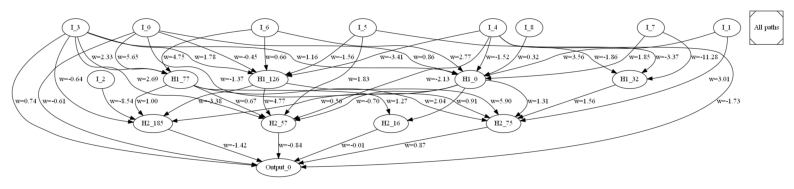

In [7]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### LIME code

In [8]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 1))
    else:
        preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            # preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=variable_names, class_names=["rings"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='regression'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=len(variable_names),  # Number of features to include in the explanation
        num_samples=2_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=variable_names):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

#### SHAP code

In [9]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=1_000, batch_size=256)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = variable_names):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

### Number of rings: 10 

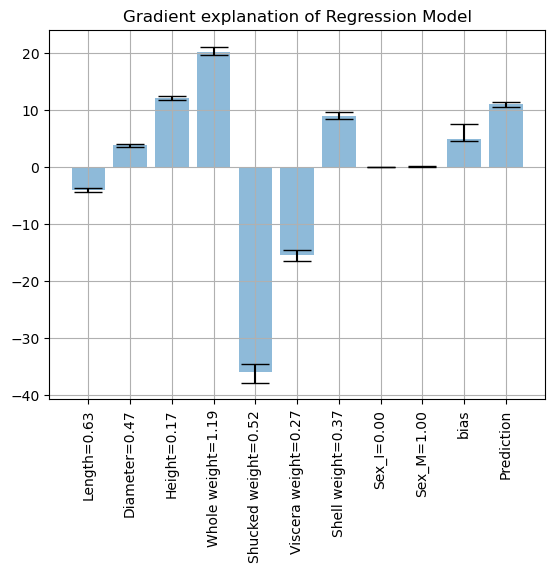

In [105]:
i = 106
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
preds = torch.zeros((n_samples,1))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]
    preds[j,0] = output

bias_explanation = (preds.T - (explanation*explain_this).sum(1)).T

var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")
# remove variables that does not contribute to the prediction at all
var_names_label_i.append("bias")
var_names_label_i.append("Prediction")

expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
expl = np.concatenate((expl, bias_explanation.cpu().detach().numpy()),1)
expl = np.concatenate((expl, preds.cpu().detach().numpy()),1)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
# plt.figure(figsize=(10, 6))
plt.bar(range(p+2), means, yerr=(bottom, top), align='center', alpha=0.5, ecolor='black', capsize=10)
# plt.xlabel('Input Variable')
# plt.ylabel('Gradient')
plt.title('Gradient explanation of Regression Model')
plt.xticks(range(p+2), [f'{var_names_label_i[i]}' for i in range(p+2)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
# plt.tight_layout()
plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

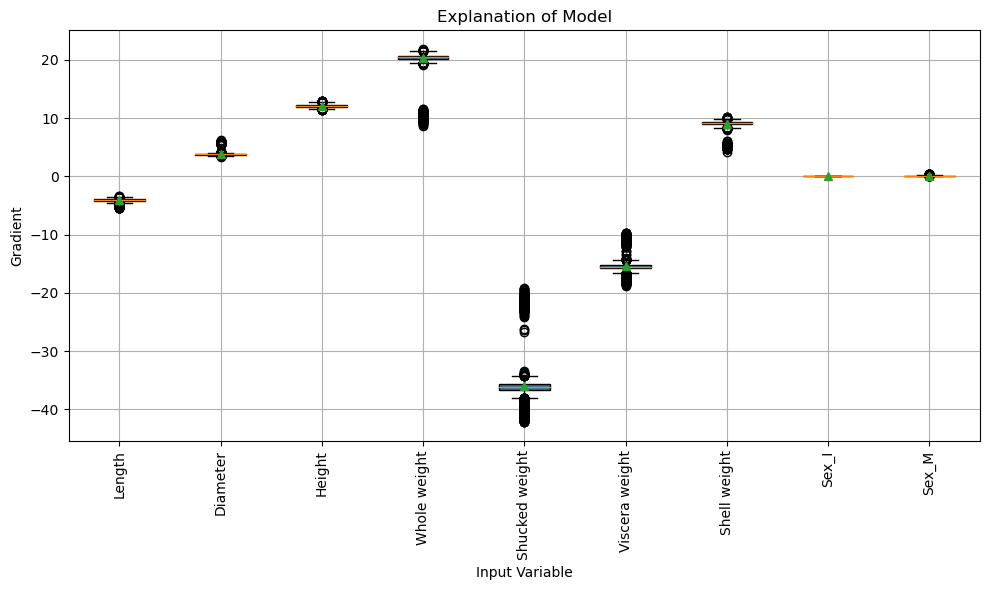

In [11]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(expl, vert=True, patch_artist=True, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, p + 1), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

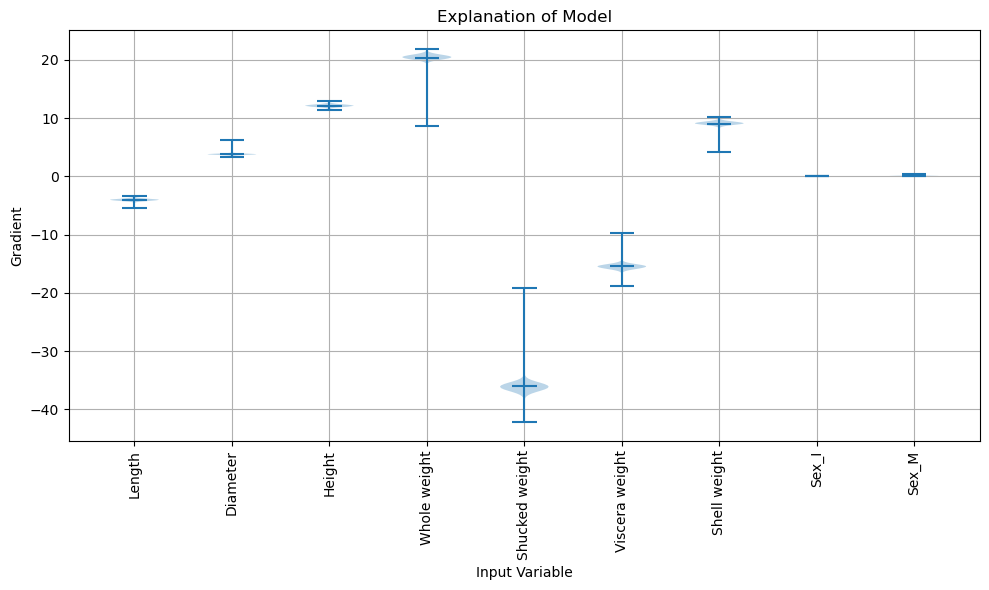

In [12]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.violinplot(expl, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, len(variable_names) + 1), variable_names, rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

#### Empirical approach

True class: 10.0


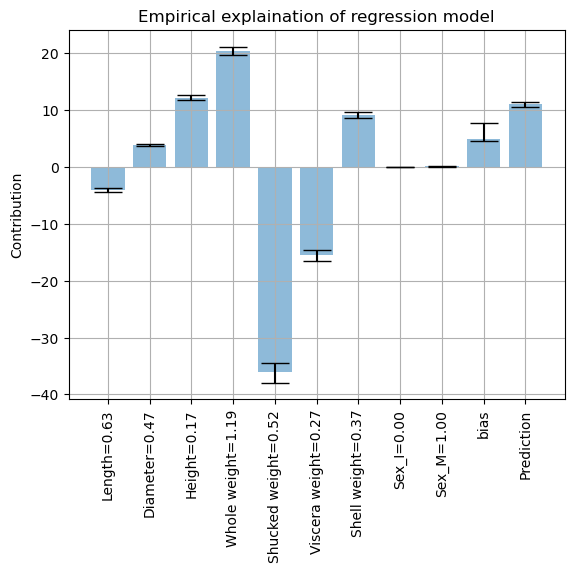

In [ ]:
i = 106
explain_this = test_dat[i,:-1].reshape(-1, p)
var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")
    
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=var_names_label_i, magnitude=True)

True class: 10.0


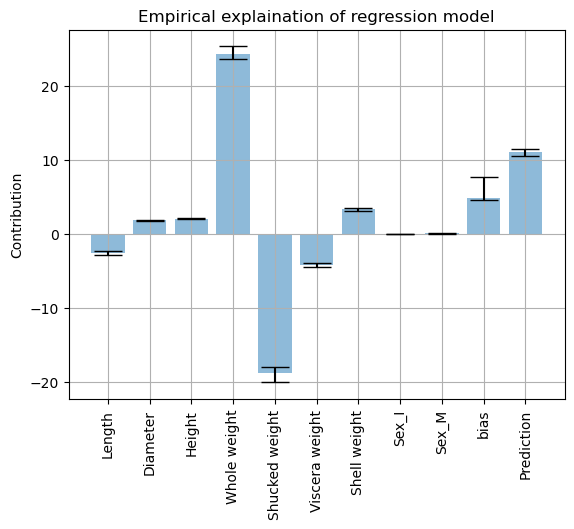

In [11]:
i = 106
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

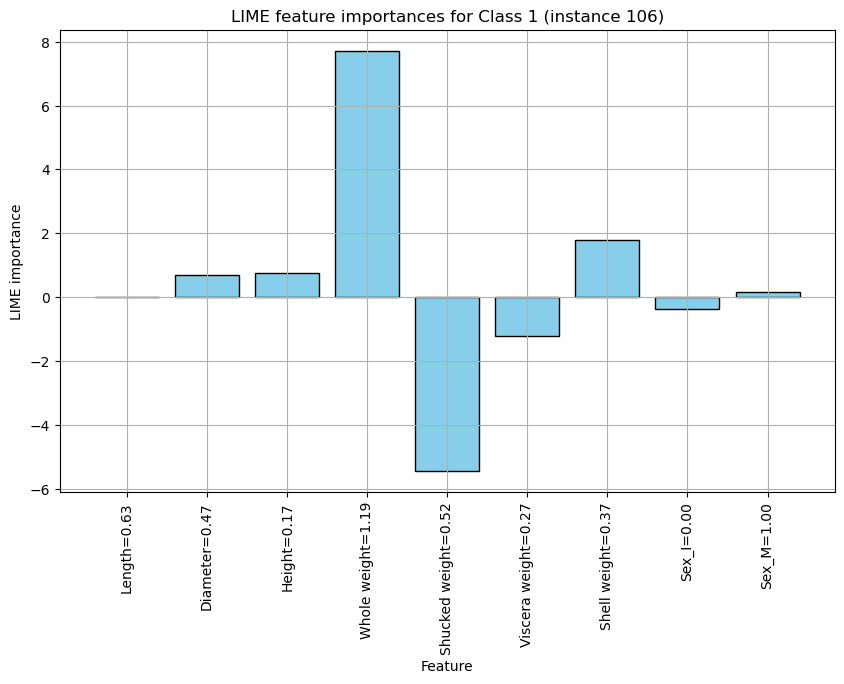

In [20]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i, names_features=var_names_label_i)

In [21]:
exp.local_exp[1]

[(3, 7.711559107960836),
 (4, -5.43812318060267),
 (6, 1.8040342772864366),
 (5, -1.2039711634952024),
 (2, 0.7585560192135822),
 (1, 0.6932440869230501),
 (7, -0.36248731696998304),
 (8, 0.1501633877107247),
 (0, 0.012324143934427358)]

#### SHAP explanation

Exact explainer: 2it [09:52, 592.42s/it]              


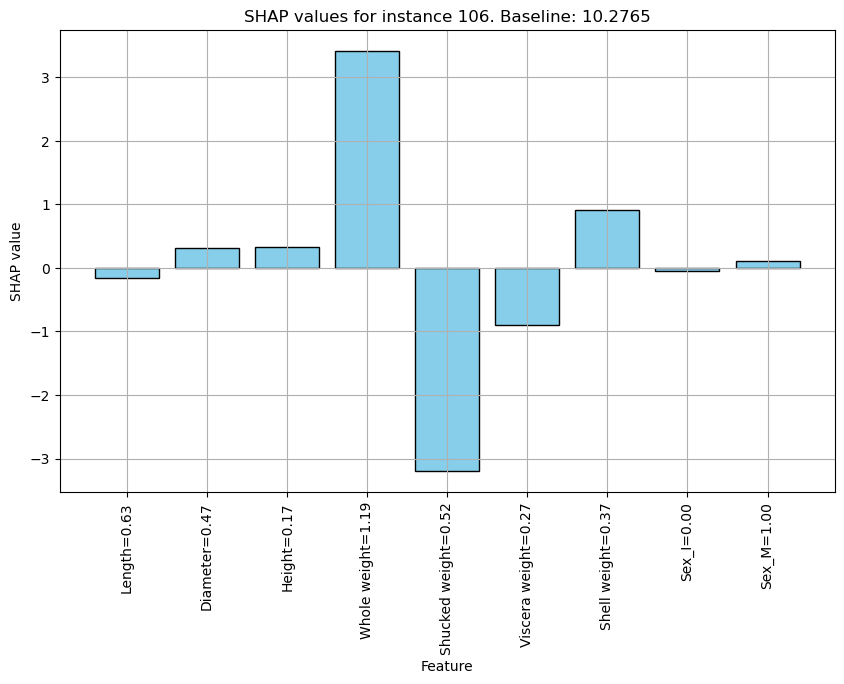

In [22]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i, feature_names=var_names_label_i)

In [23]:
shap_vals

.values =
array([[-0.16799577,  0.30949472,  0.32857816,  3.41124546, -3.19415524,
        -0.9081429 ,  0.91342159, -0.04659197,  0.102865  ]])

.base_values =
array([[10.27648131]])

.data =
array([[0.635 , 0.475 , 0.17  , 1.1935, 0.5205, 0.2695, 0.3665, 0.    ,
        1.    ]])

### Number of rings: 17

In [103]:
i = 201
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
preds = torch.zeros((n_samples,1))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]
    preds[j,0] = output

bias_explanation = (preds.T - (explanation*explain_this).sum(1)).T

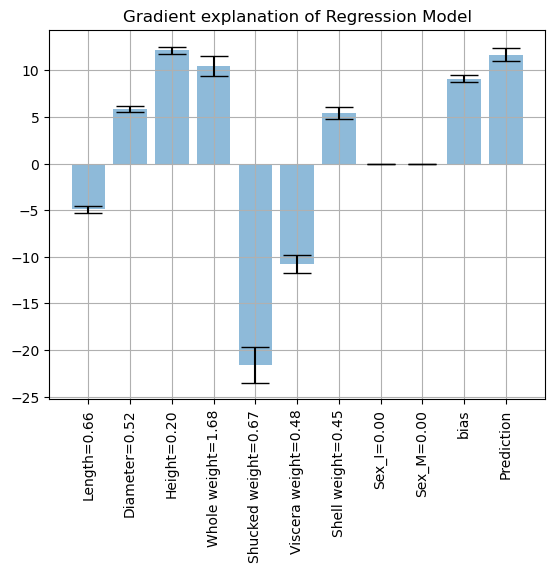

In [104]:
var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")
# remove variables that does not contribute to the prediction at all
var_names_label_i.append("bias")
var_names_label_i.append("Prediction")

expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
expl = np.concatenate((expl, bias_explanation.cpu().detach().numpy()),1)
expl = np.concatenate((expl, preds.cpu().detach().numpy()),1)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
# plt.figure(figsize=(10, 6))
plt.bar(range(p+2), means, yerr=(bottom, top), align='center', alpha=0.5, ecolor='black', capsize=10)
# plt.xlabel('Input Variable')
# plt.ylabel('Gradient')
plt.title('Gradient explanation of Regression Model')
plt.xticks(range(p+2), [f'{var_names_label_i[i]}' for i in range(p+2)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
# plt.tight_layout()
plt.savefig("imgs/local_explain_grad_based_17.png")
plt.show()

#### Empirical approach

True class: 17.0


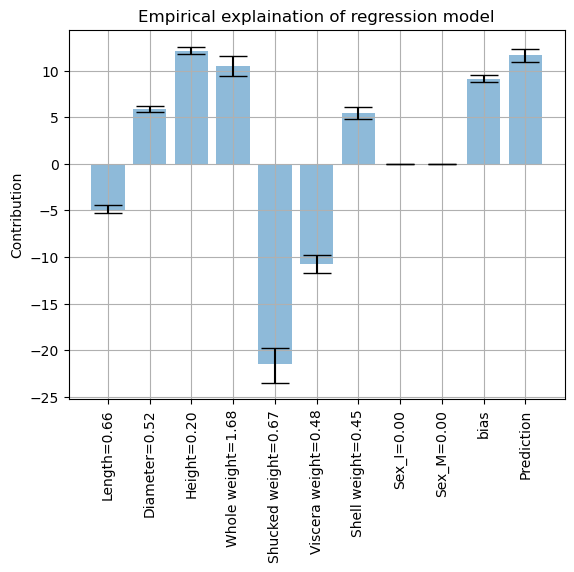

In [38]:
i = 201
explain_this = test_dat[i,:-1].reshape(-1, p)
var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=var_names_label_i, magnitude=True)

True class: 17.0


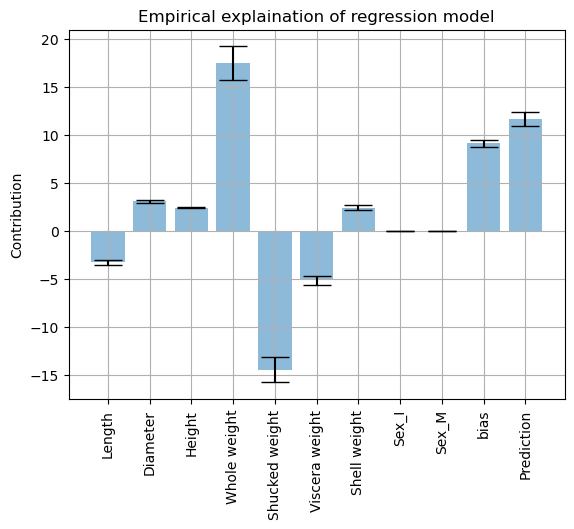

In [17]:
i = 201
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

In [26]:
var_names_label_i

['Length=0.63',
 'Diameter=0.47',
 'Height=0.17',
 'Whole weight=1.19',
 'Shucked weight=0.52',
 'Viscera weight=0.27',
 'Shell weight=0.37',
 'Sex_I=0.00',
 'Sex_M=1.00']

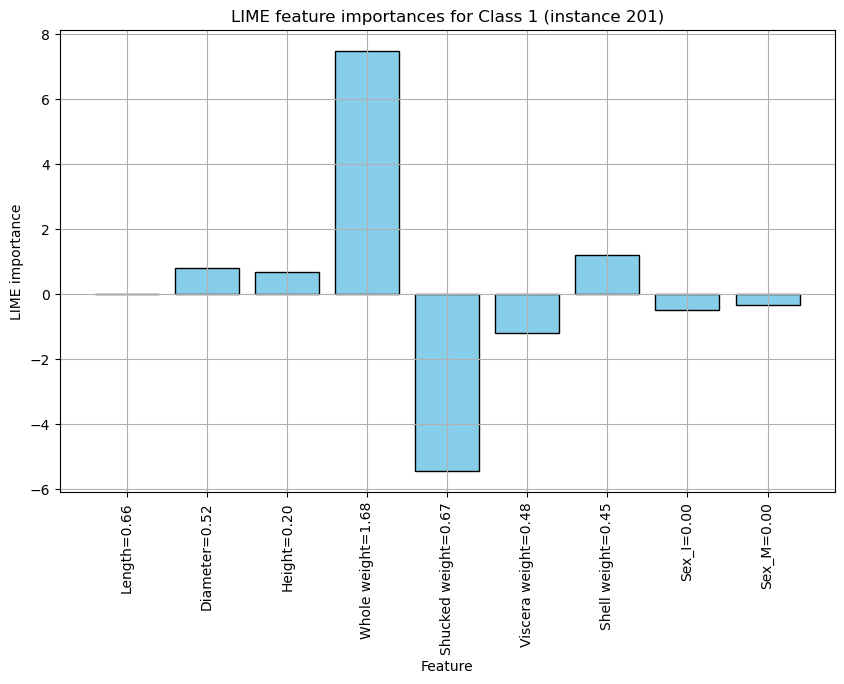

In [39]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i, names_features=var_names_label_i)

In [40]:
exp.local_exp[1]

[(3, 7.491967451137785),
 (4, -5.451477903989881),
 (5, -1.2052909747158507),
 (6, 1.1851532685217445),
 (1, 0.8033825793151158),
 (2, 0.6900210459296041),
 (7, -0.5012742425528655),
 (8, -0.35254554211336847),
 (0, -0.009712078879944887)]

#### SHAP explanation

Exact explainer: 2it [16:48, 1008.83s/it]             


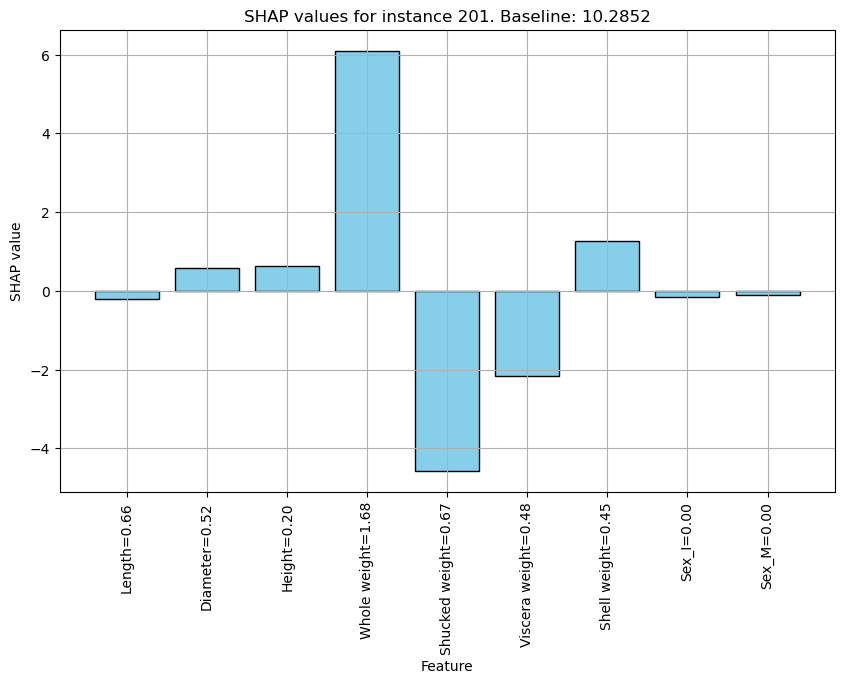

In [41]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i, var_names_label_i)

In [42]:
shap_vals

.values =
array([[-0.2109745 ,  0.5842951 ,  0.6446183 ,  6.09531968, -4.5691574 ,
        -2.15943928,  1.26969098, -0.15690359, -0.09565936]])

.base_values =
array([[10.28521881]])

.data =
array([[0.66  , 0.52  , 0.2   , 1.676 , 0.673 , 0.4805, 0.45  , 0.    ,
        0.    ]])

### Number of rings: 8

In [106]:
i = 200
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
preds = torch.zeros((n_samples,1))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]
    preds[j,0] = output

bias_explanation = (preds.T - (explanation*explain_this).sum(1)).T

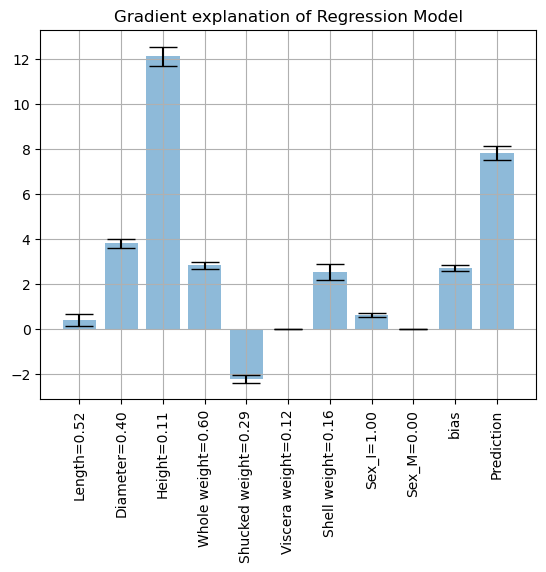

In [107]:
var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")
# remove variables that does not contribute to the prediction at all
var_names_label_i.append("bias")
var_names_label_i.append("Prediction")

expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
expl = np.concatenate((expl, bias_explanation.cpu().detach().numpy()),1)
expl = np.concatenate((expl, preds.cpu().detach().numpy()),1)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
# plt.figure(figsize=(10, 6))
plt.bar(range(p+2), means, yerr=(bottom, top), align='center', alpha=0.5, ecolor='black', capsize=10)
# plt.xlabel('Input Variable')
# plt.ylabel('Gradient')
plt.title('Gradient explanation of Regression Model')
plt.xticks(range(p+2), [f'{var_names_label_i[i]}' for i in range(p+2)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
# plt.tight_layout()
plt.savefig("imgs/local_explain_grad_based_8.png")
plt.show()

#### Empirical approach

True class: 8.0


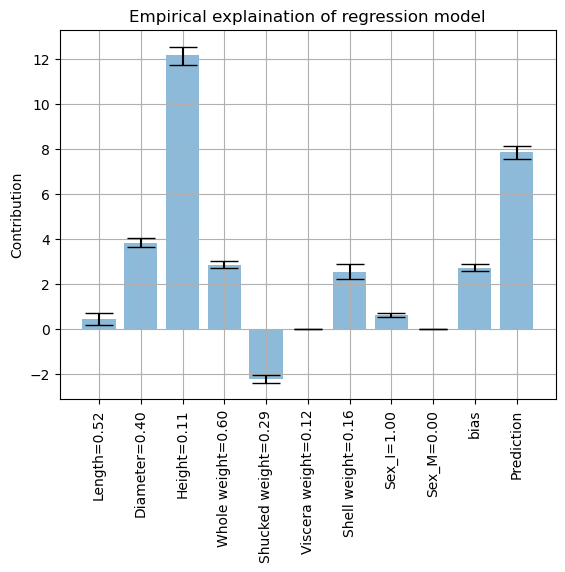

In [31]:
i = 200
explain_this = test_dat[i,:-1].reshape(-1, p)
var_names_label_i = []
for j in range(len(variable_names)):
    var_names_label_i.append(variable_names[j]+f"={explain_this[0,j]:.2f}")

print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=var_names_label_i, magnitude=True)

True class: 8.0


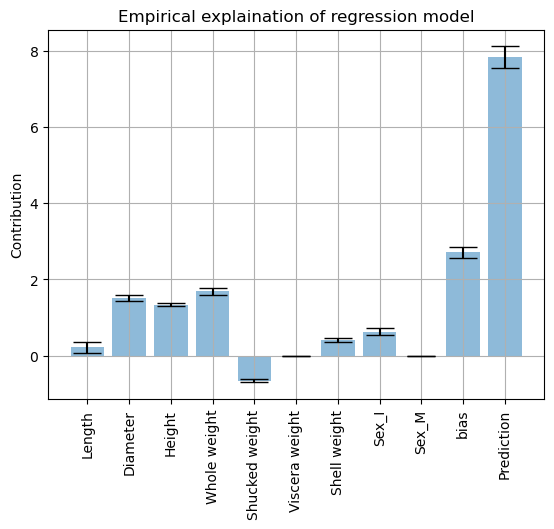

In [23]:
i = 200
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, class_names=["regression model"], variable_names=variable_names)

#### Lime explanation

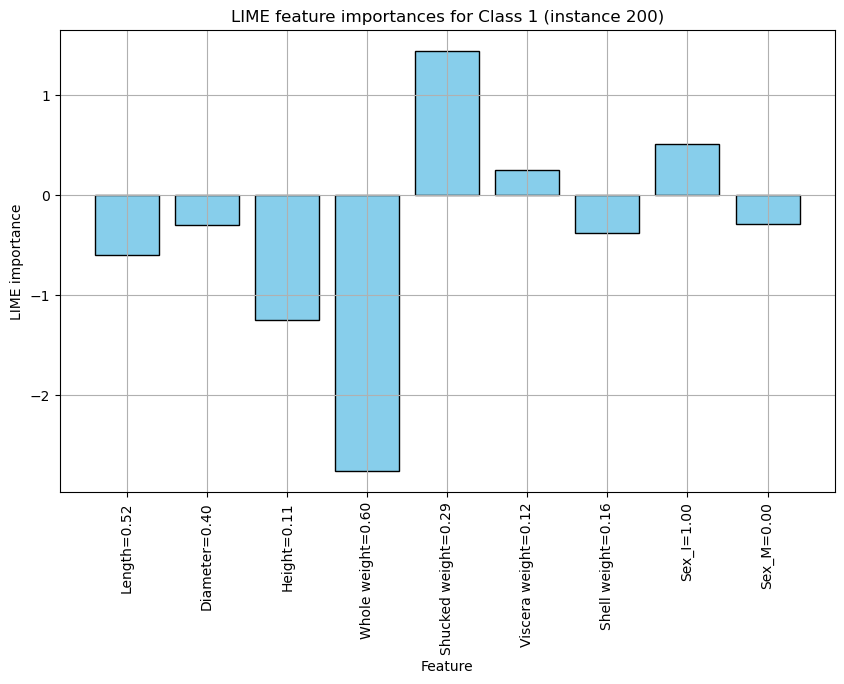

In [32]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i, names_features=var_names_label_i)

In [33]:
exp.local_exp[1]

[(3, -2.758416224316547),
 (4, 1.438509144160538),
 (2, -1.253784056886616),
 (0, -0.6000220961578052),
 (7, 0.5106527576910188),
 (6, -0.38363821809566795),
 (1, -0.2988232224646384),
 (8, -0.2949194355825097),
 (5, 0.2444965972206325)]

#### SHAP explanation

Exact explainer: 2it [10:33, 633.49s/it]              


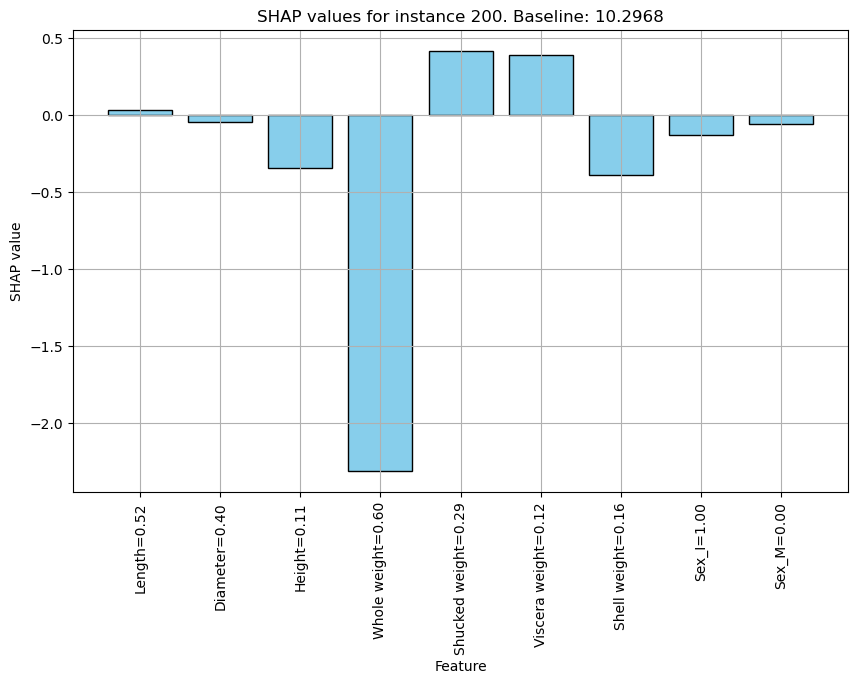

In [34]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i, var_names_label_i)

In [35]:
shap_vals

.values =
array([[ 0.03220823, -0.04542851, -0.3455094 , -2.31188588,  0.41423678,
         0.38851323, -0.38996332, -0.13199283, -0.05780401]])

.base_values =
array([[10.29676097]])

.data =
array([[0.52  , 0.4   , 0.11  , 0.597 , 0.2935, 0.1155, 0.16  , 1.    ,
        0.    ]])